# Sistema de recomendação
A partir do perfil dos clientes que já realizaram compras na feira, serão criados grupos de perfis de clientes com base nos produtos comprados. Esses grupos poderão ser então utilizados para realização de recomendações de produtos a serem sugeridas ao longo do processo de compra em pedidos futuros, classificando-se o cliente em algum dos grupos de perfil e sugerindo-se produtos deste grupo ao cliente.<p>
Inicialmente faremos o agrupamento dos clientes utilizando K-Means, dada sua boa performance para grande quantidade de dados quando comparado a outras opções como, por exemplo, Hierarchical Clustering. DBSCAN foi descartado pois sua detecção de outliers traria complicações indesejadas.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

Dentre os data sets que temos disponíveis, o mais apropriado para esta situação é o que contém informações de pedidos em formato wide.

In [2]:
df = pd.read_csv('arquivos/pedidos_wide_final.csv')
df.head()

,id_pedido,data_pedido,hora_pedido,id_cliente,bairro_pedido,cidade_pedido,cep_pedido,tipo_pagamento,agente,i_agua de coco,...,vl_tot_pimentao [ 500g ],i_abobrinha,qt_abobrinha,vl_tot_abobrinha,i_quiabo [ kg ],qt_quiabo [ kg ],vl_tot_quiabo [ kg ],i_pepino amarelo [ unidade ],qt_pepino amarelo [ unidade ],vl_tot_pepino amarelo [ unidade ]
0,54,2020-07-03,11:30:53,39,aldeota,fortaleza,60150060,Pagar ao retirar na loja,android,True,...,0.0,False,0.0,0.0,False,0.0,0.0,False,0.0,0.0
1,56,2020-07-03,11:32:27,38,sao gerardo,fortaleza,60320105,Cartão de Crédito,windows,False,...,0.0,False,0.0,0.0,False,0.0,0.0,False,0.0,0.0
2,59,2020-07-03,11:38:01,35,manoel satiro,fortaleza,60713480,Cartão de Crédito,windows,False,...,0.0,False,0.0,0.0,False,0.0,0.0,False,0.0,0.0
3,60,2020-07-03,11:38:27,33,rodolfo teofilo,fortaleza,60431075,Débito/Transferência,android,True,...,0.0,False,0.0,0.0,False,0.0,0.0,False,0.0,0.0
4,64,2020-07-03,11:49:13,40,rodolfo teofilo,fortaleza,60430660,Cartão de Crédito,android,False,...,0.0,False,0.0,0.0,False,0.0,0.0,False,0.0,0.0


## Criação dos grupos de clientes com K-Means
Optaremos por utilizar a quantidade de cada produto comprada pelos clientes, dado que tal informação nos traz conhecimento mais aprofundado sobre os clientes. Há mais informação em saber que um cliente comprou dez garrafas de cajuína do que simplesmente saber que ele comprou cajuína, por exemplo, já que um cliente que comprou sete garrafas está mais próximo de um outro que comprou dez do que um terceiro que comprou somente uma.

In [3]:
# Selecionando as colunas de interesse: as que contém quantidade de itens por produtos
cols_int = [col for col in df.columns if 'qt_' in col and col != 'qt_final_itens']

X = df[cols_int]
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

A escolha da quantidade de grupos se dará por meio do método do cotovelo. Testaremos diversos valores para K (quantidade de clusters) e verificaremos a clareza na separação dos grupos. A forma de quantificar esta clareza é através da medição da soma do quadrado das distâncias (SSD) de cada ponto para o centro de seu cluster. Enquanto o aumento de K estiver resultando em decréscimo significativo de SSD, continuaremos aumentando K. Quando este decréscimo reduzir, não mais vale a pena aumentar K. Testaremos valores de K entre 2 e 200.

In [4]:
ssd = list()

for k in range(2,200):
    modelo_kmeans = KMeans(n_clusters=k)
    modelo_kmeans.fit(scaled_X)
    
    ssd.append(modelo_kmeans.inertia_) # Aqui está SSD.

Vamos visualizar graficamente o progresso do valor de SSD conforme K foi aumentado e procurar pelo cotovelo queda demonstra que inexpressiva de SSD para descobrirmos o melhor valor para K.

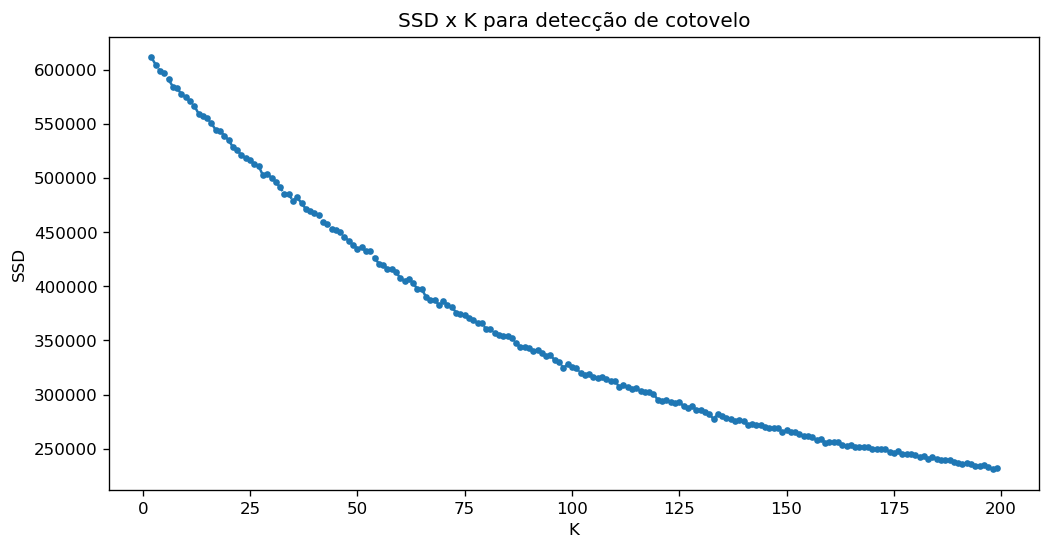

In [5]:
plt.figure(dpi=120,figsize=(10,5))
plt.xlabel('K')
plt.ylabel('SSD')
plt.title('SSD x K para detecção de cotovelo')
plt.plot(range(2,200),ssd,'.--');

Como a quantidade de produtos é bastante grande, não queremos uma quantidade de clusters (K) muito pequena para evitar perfis de clientes muito genéricos. Por esta razão, ignoraremos alguns pontos onde K ainda é pequeno e SSD não reduziu significativamente com K + 1. Perceba também um cotovelo bastante interessante na área onde K está entre 25 e 50.

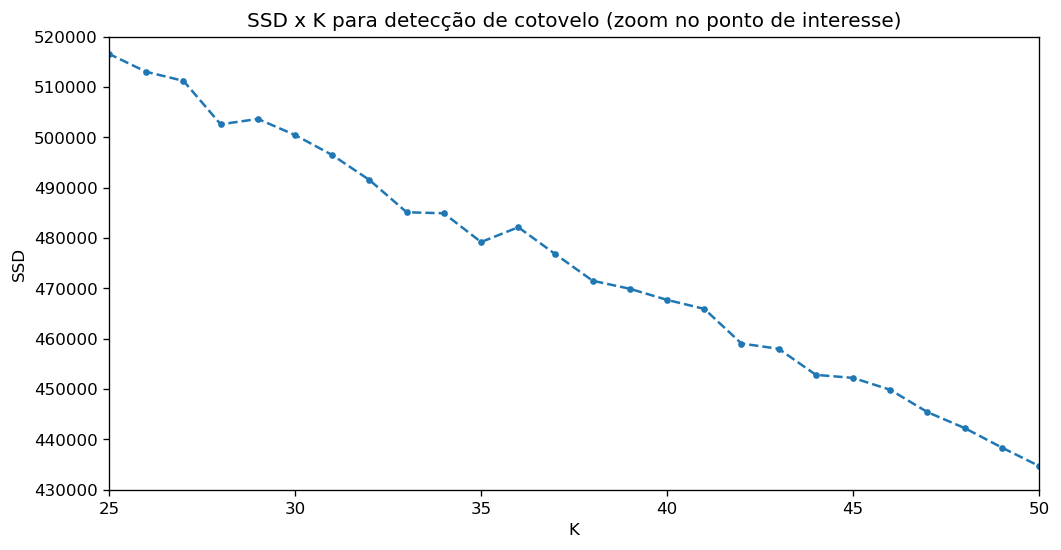

In [6]:
plt.figure(dpi=120,figsize=(10,5))
plt.xlabel('K')
plt.ylabel('SSD')
plt.title('SSD x K para detecção de cotovelo (zoom no ponto de interesse)')
plt.xlim(25,50)
plt.ylim(430000,520000)
plt.plot(range(2,200),ssd,'.--');

Podemos ver que SSD com K = 36 é maior que SSD com K = 35, portanto 35 é um bom valor para K. Vamos classificar os pedidos dentro desses 35 grupos.<p>
**Importante:** este modelo deve ser retreinado sempre que houver acréscimo ou remoção de produtos no inventário de produtos. Também deve ser retreinado com alguma frequência para levar em consideração compras mais recentes.

In [11]:
modelo_kmeans = KMeans(n_clusters=35)
labels = modelo_kmeans.fit_predict(scaled_X)
df['grupo'] = labels

Quantos pedidos temos por grupo?

In [12]:
df['grupo'].value_counts()

5     1579
32     754
17     323
22     202
0      158
8      118
23      91
13      51
18      50
3       28
16      25
9       19
20      19
15      13
1       11
27      11
30       9
21       9
26       9
24       6
4        6
11       6
28       5
12       5
14       5
29       4
2        3
25       1
7        1
10       1
33       1
31       1
34       1
19       1
6        1
Name: grupo, dtype: int64

Dada a quantidade de partâmetros que temos em X, o mapa de calor a seguir torna-se bastante difícil de ler. Mesmo assim, ele é visualizável caso aberto em outra aba pois foi gerado com resolução bastante alta. Não é possível aprender muita coisa dele, mas podemos perceber que alguns grupos pois correlção mais direta com algum produto específico. Alguns padrões de compra também são verificáveis.

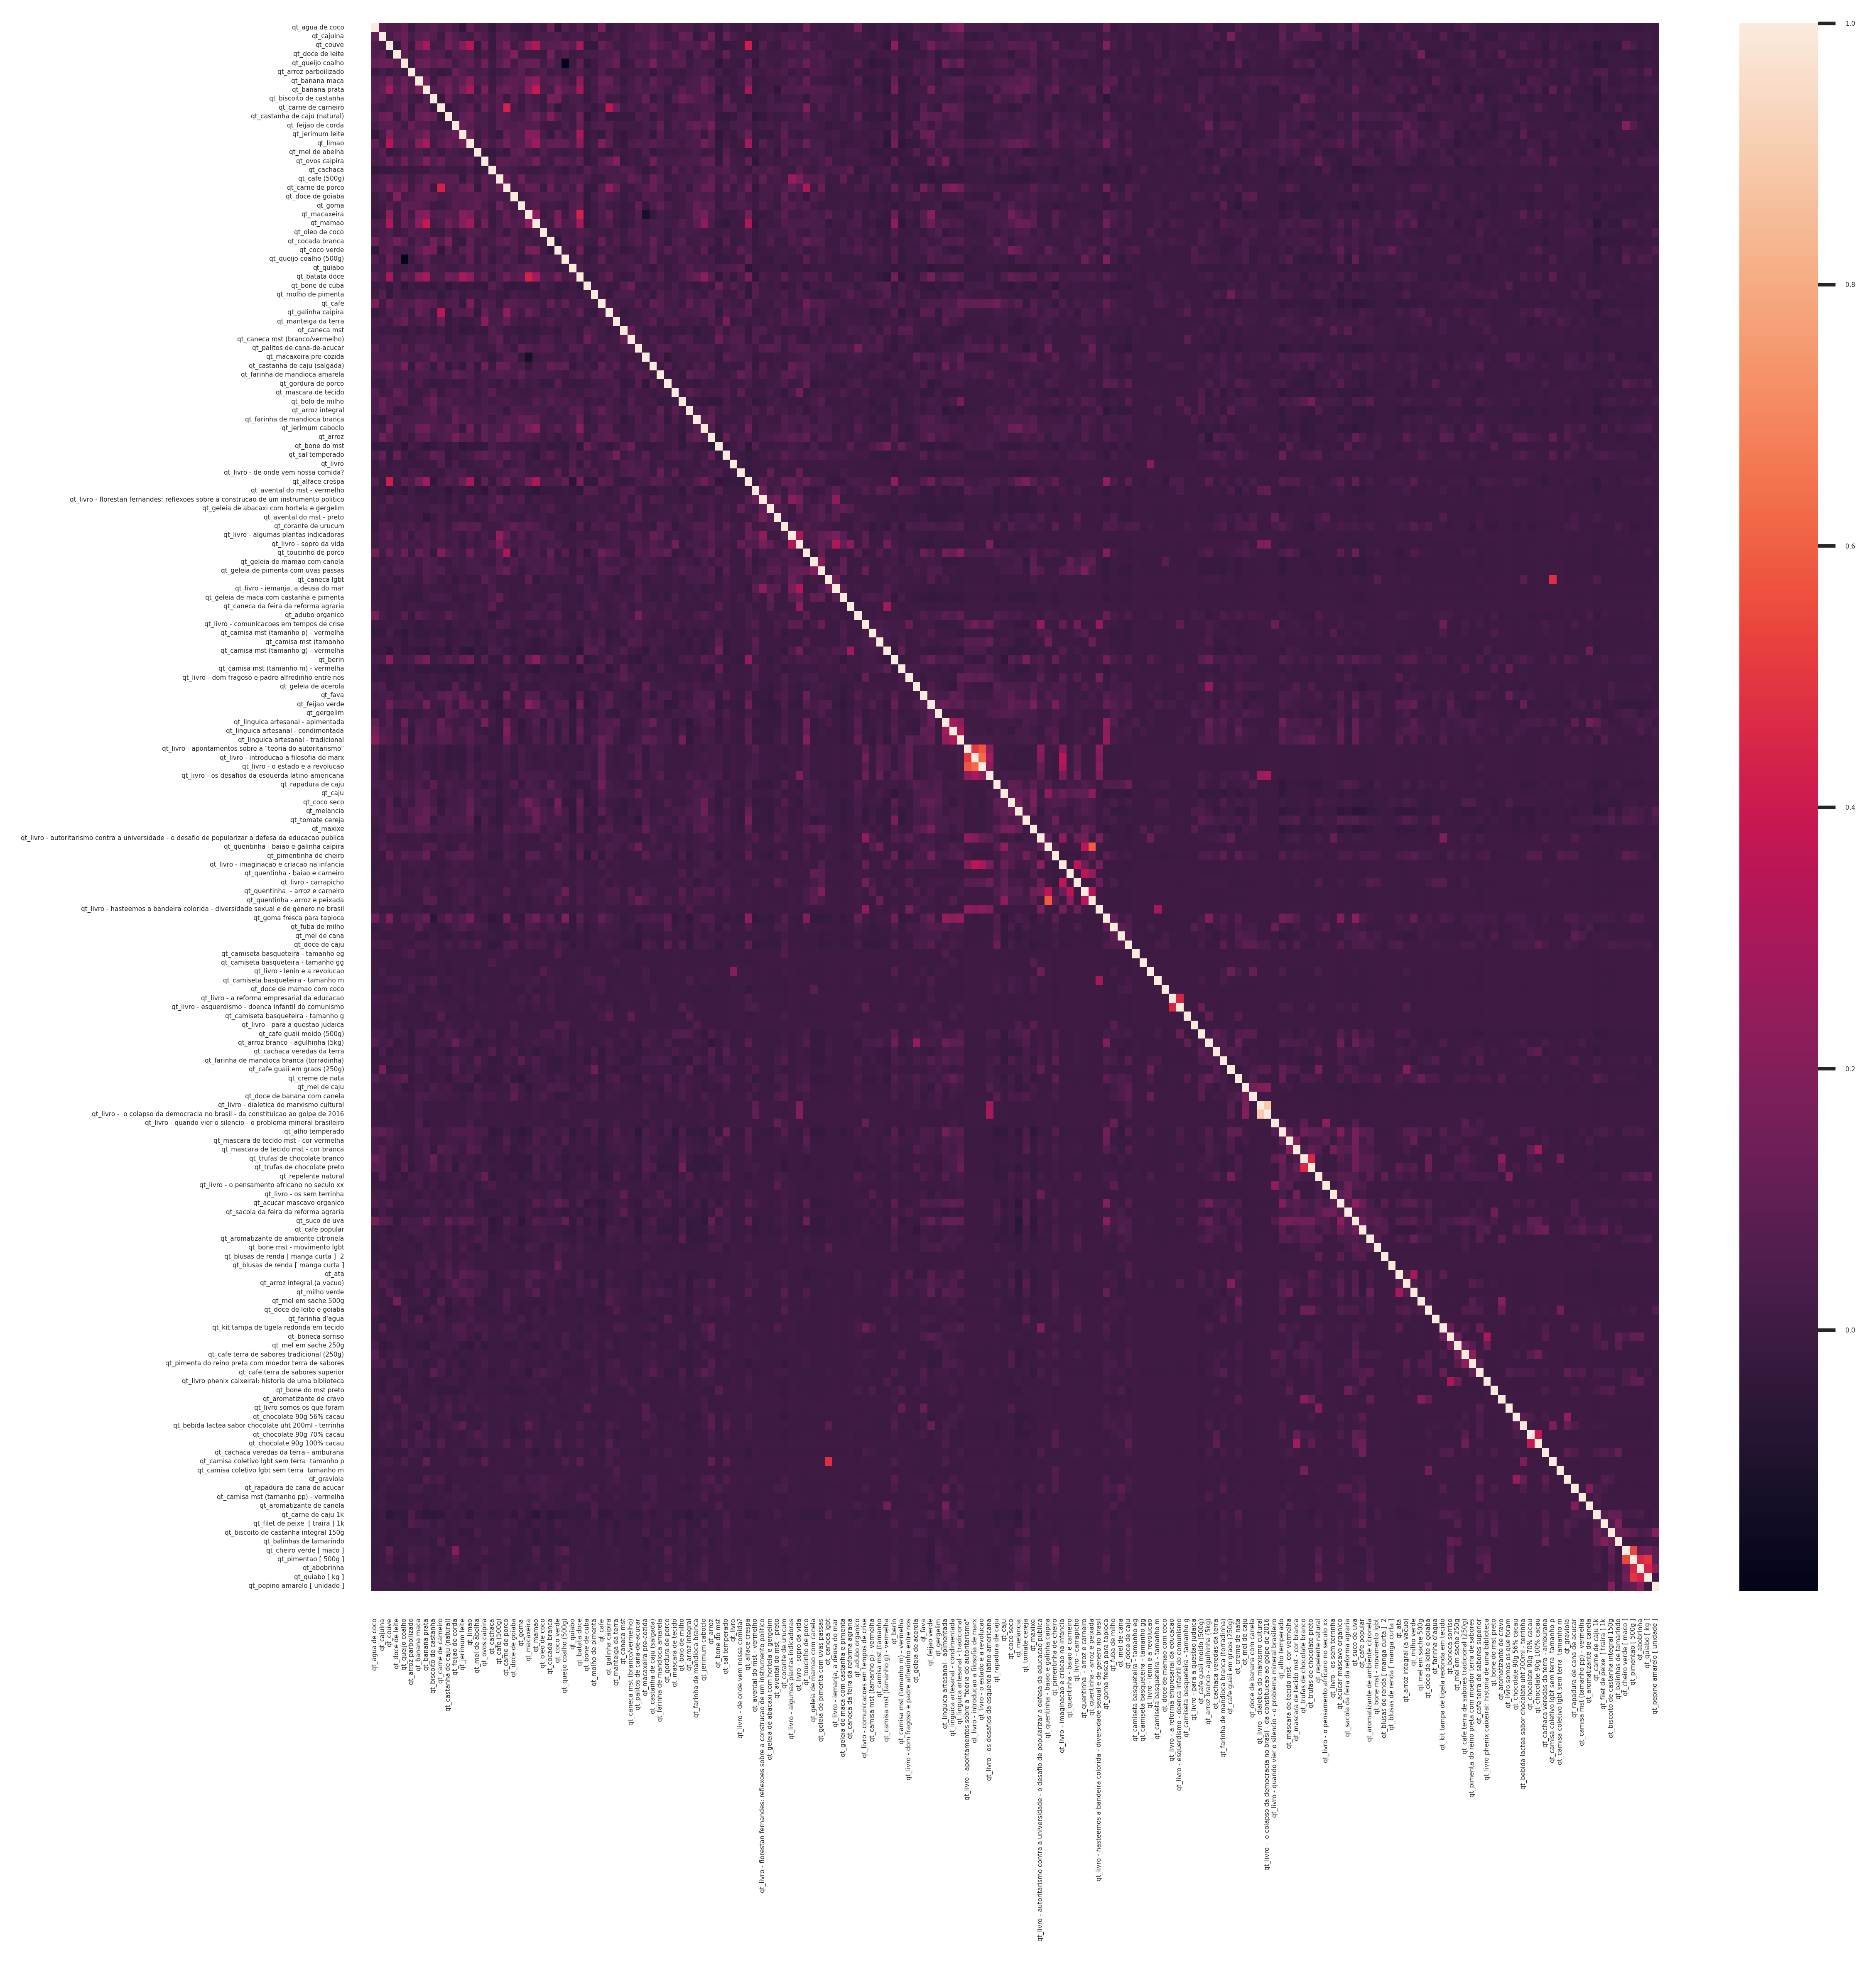

In [13]:
plt.figure(dpi=500,figsize=(10,10))
sns.set(font_scale=0.2)
sns.heatmap(X.corr());

É necessário descobrir quais os produtos mais populares para cada grupo.

In [14]:
prods_grupos = dict()

for grupo in df['grupo'].unique():
    prods_grupo = list() # Lista de produtos, do mais popular para o menos popular, onde quantidade de produtos > 0
    lista_prods = df[df['grupo'] == grupo][cols_int].sum().sort_values(ascending=False)
    
    for i in range(0,len(lista_prods)):
        if lista_prods.values[i] > 0:
            prods_grupo.append(lista_prods.index[i])
        else:
            break
            
    prods_grupos[grupo] = [prod[3:] for prod in prods_grupo]

Abaixo podemos ver um dicionário com uma lista de produtos para cada grupo, estando eles dos mais populares para os menos populares.

In [15]:
prods_grupos

{5: ['cajuina',
  'ovos caipira',
  'biscoito de castanha',
  'mel de abelha',
  'banana prata',
  'queijo coalho (500g)',
  'castanha de caju (natural)',
  'agua de coco',
  'couve',
  'limao',
  'batata doce',
  'mamao',
  'queijo coalho',
  'macaxeira pre-cozida',
  'castanha de caju (salgada)',
  'goma',
  'doce de leite',
  'feijao verde',
  'feijao de corda',
  'coco verde',
  'cocada branca',
  'arroz',
  'goma fresca para tapioca',
  'alface crespa',
  'adubo organico',
  'galinha caipira',
  'carne de carneiro',
  'jerimum leite',
  'carne de caju 1k',
  'macaxeira',
  'carne de porco',
  'rapadura de caju',
  'cafe',
  'linguica artesanal - condimentada',
  'jerimum caboclo',
  'manteiga da terra',
  'doce de goiaba',
  'milho verde',
  'linguica artesanal - tradicional',
  'banana maca',
  'coco seco',
  'doce de caju',
  'arroz integral',
  'corante de urucum',
  'sal temperado',
  'gergelim',
  'bone de cuba',
  'geleia de acerola',
  'alho temperado',
  'gordura de porco'

Vamos validar se o produtos no dicionário estão corretos verificando os produtos mais populares do grupo 5 diretamente no DataFrame.

In [18]:
df[df['grupo'] == 5][cols_int].sum().sort_values(ascending=False)

qt_cajuina                                     645.0
qt_ovos caipira                                612.0
qt_biscoito de castanha                        554.0
qt_mel de abelha                               500.0
qt_banana prata                                472.0
                                               ...  
qt_pimentinha de cheiro                          0.0
qt_quentinha - baiao e galinha caipira           0.0
qt_bone do mst preto                             0.0
qt_aromatizante de cravo                         0.0
qt_livro - imaginacao e criacao na infancia      0.0
Length: 176, dtype: float64

Podemos ver que o dicionário está correto.<p>
**Importante:** ao implantar em produção, esse dicionário deve ser exportado juntamente com o modelo classificador que modelaremos a seguir. O sistema da loja deverá chamar o modelo classificador para descobrir o grupo do cliente e, em seguida, consultar este dicionário para saber quais produtos recomendar, não esquecendo de ignorar produtos que já estejam no carrinho de compras. Produtos que não estiverem disponíveis em estoque também deveriam ser ignorados.

## Classificando um carrinho de compras ativo em um dos grupos
Criados os grupos, podemos treinar alguns modelos de <u>classiicação</u> e compará-los para descobrir qual conseguiria fazer melhor predição de recomendações. Testaremos alguns modelos e compararemos suas performances para decidir qual é o mais apropriado.<p>
Utilizaremos Grid Search para otimização de hiper parâmetros e Cross Validation para melhor utilização da massa para treinamento e teste. Os dados serão separados da seguinte forma:
- 80% para treinamento;
- 10% para teste;
- 10% para avaliação final do modelo.

In [20]:
# Determinando X e y
X = df[cols_int]
y = df['grupo']

# Separando a massa conforme descrito acima
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_holdout, X_test, y_holdout, y_test = train_test_split(X_test, y_test, test_size=0.5)

Vamos verificar o tamanho dos grupos para garantir que a separação se deu de forma correta.

In [21]:
print(f"Tamanho de X: {len(X)}")
print(f"Tamanho de y: {len(y)}")
print(f"Tamanho de X_train: {len(X_train)}")
print(f"Tamanho de y_train: {len(y_train)}")
print(f"Tamanho de X_test: {len(X_test)}")
print(f"Tamanho de y_test: {len(y_test)}")
print(f"Tamanho de X_holdout: {len(X_holdout)}")
print(f"Tamanho de y_holdout: {len(y_holdout)}")

Tamanho de X: 3527
Tamanho de y: 3527
Tamanho de X_train: 2821
Tamanho de y_train: 2821
Tamanho de X_test: 353
Tamanho de y_test: 353
Tamanho de X_holdout: 353
Tamanho de y_holdout: 353


Normalizando os dados.

In [22]:
scaler = StandardScaler()
scaler.fit(X_train) # Fit somente com dados de treinamento para evitar data leakage
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)
scaled_X_holdout = scaler.transform(X_holdout)

Vamos criar uma função genérica que irá nos mostrar métricas de performance do modelos que testaremos.

In [34]:
def reportar(model):
    y_pred = model.predict(scaled_X_test)
    print(f"Melhores parâmetros: {model.best_params_}")
    print(classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test,y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.show()
    return classification_report(y_test,y_pred)

### Regressão logística
Trata-se do modelo mais simples de classificação. Consiste de uma adaptação da regressão linear, utilizando-se de uma função sigmóide para decidir se um grupo de parâmetros pertence a uma classe (1) ou não (0). Sua performance computacional normalmente deixa a desejar quando comparada a modelos mais modernos.<p>
Testaremos a aplicação das técnicas de redução de complexidade ridge (l1) e lasso (l2), assim como elasticnet, que é uma mistura das duas, tentando atingir a melhor performance do modelo. O emprego dessas técnicas diminuem a chance de overfitting ocorrer Serão mostradas algumas mensagens de warning porque o parâmetro <code>l1_ratio</code>, que determina a quantidade de ridge no elasticnet, só faz sentido quando elasticnet está sendo usado. Também testaremos alguns valores para o hiper parâmetro <code>C</code>, que determina a força da regularização. Um número máximo de iteração também será informado para diminuir os warnings devido à impossibilidade de convergência do modelo.

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when pe

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when pena

Melhores parâmetros: {'C': 1.0, 'l1_ratio': 0.0, 'max_iter': 1000, 'penalty': 'l2'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.75      1.00      0.86         3
           3       0.50      0.50      0.50         2
           5       0.95      0.99      0.97       163
           8       0.91      1.00      0.95        10
           9       1.00      1.00      1.00         3
          11       0.00      0.00      0.00         2
          13       0.80      0.80      0.80         5
          15       1.00      1.00      1.00         1
          16       1.00      0.67      0.80         3
          17       0.95      0.90      0.92        40
          18       1.00      1.00      1.00         2
          20       1.00      1.00      1.00         3
          21       0.00      0.00      0.00         2
          22       0.94      1.00      0.97        15
          23       0.90      0.90      0.90        

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

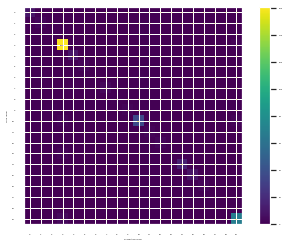

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [35]:
modelo_log = LogisticRegression()

penalty = ['l1','l2','elasticnet'] # 3 técnicnas de redução de complexidade
l1_ratio = np.linspace(0,1,3) # 3 valores de l1_ratio
C = np.logspace(0,10,5) # 5 valores de C
max_iter = [1000]
param_grid = {'penalty':penalty,'l1_ratio':l1_ratio,'C':C,'max_iter':max_iter}

modelo_grid_log = GridSearchCV(modelo_log,param_grid=param_grid)
modelo_grid_log.fit(scaled_X_train,y_train)
cr_log = reportar(modelo_grid_log)

### Support vector machines
Basicamente, SVM separa pontos em um plano cartesiano multidimensional com hiper planos. Esta separação define as classes. Os dados são projetados em uma quantidade maior de dimensões o que permite que separações que não são possíveis na quantidade "normal" de dimensões sejam realizadas. Um classificador de tamanho de margem pode ser determinado para definir uma tolerância de existência de pontos de uma classe em uma partição que não é a da sua classe. Há diversos kernels se aproximam do problema de forma distinta. Testaremos algumas das possíveis combinações com Grid Search.

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Melhores parâmetros: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         3
           3       0.50      0.50      0.50         2
           5       0.93      1.00      0.96       163
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         1
          16       1.00      0.67      0.80         3
          17       0.94      0.80      0.86        40
          18       1.00      1.00      1.00         2
          20       1.00      1.00      1.00         3
          21       1.00      1.00      1.00         2
          22       1.00      1.00      1.00        15
          23       1.00      0.80      0.89        1

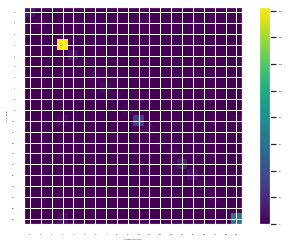

In [36]:
modelo_svm = SVC()

C = [0.001,0.01,0.1,0.5,1]
kernel = ['linear','rbf','poly']
gamma = ['scale','auto']
degree = [2,3,4]
param_grid = {'C':C,'kernel':kernel,'gamma':gamma,'degree':degree}

modelo_grid_svm = GridSearchCV(modelo_svm,param_grid=param_grid)
modelo_grid_svm.fit(scaled_X_train,y_train)
cr_svm = reportar(modelo_grid_svm)

### Random forests
Random forests possuem a habilidade de aumentar consideravelmente a performance das idéias que baseiam árvores de decisões. Trata-se de um ensemble learner por utilizar-se de um conjunto de decisores para realizar predições. São criadas diversas árvores, cada uma analisando um subgrupo de parâmetros. A predição é feita por meio de contagem dos votos das várias árvores. A classe com mais votos é selecionada. No caso de regressões, onde o label é contínuo, o resultando é uma média da predição de cada árvore.<p>
Os hiper parâmetros que testaremos com Grid Search serão a quantidade e árvores a serem criadas (n_estimators, a quantidade máxima de parâmetros por árvore (max_features) e a utilização de bootstrap. Bootstraping nada mais é do que a seleção de algumas linhas, ao invés de todas, para treinamento de cada árvore. Permite que as árvores sejam mais diversificadas.<p>
Dadas todas essas aleatoriedades na seleção de linhas e colunas a serem usadas para testar cada árvore, Random Forests não corre o risco de sofrer overfitting.

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Melhores parâmetros: {'bootstrap': True, 'max_features': 50, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      0.33      0.50         3
           3       1.00      0.50      0.67         2
           5       0.82      0.98      0.89       163
           8       0.77      1.00      0.87        10
           9       1.00      0.33      0.50         3
          11       0.00      0.00      0.00         2
          13       0.50      0.40      0.44         5
          15       0.00      0.00      0.00         1
          16       1.00      0.67      0.80         3
          17       0.94      0.42      0.59        40
          18       1.00      1.00      1.00         2
          20       1.00      0.33      0.50         3
          21       1.00      1.00      1.00         2
          22       0.88      1.00      0.94        15
          23       1.00      0.20      0.33        10

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

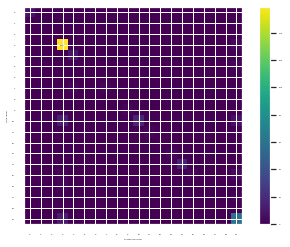

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [37]:
modelo_rf = RandomForestClassifier()

n_estimators = [64,100,128,200]
max_features = [5,10,50,100,150]
bootstrap = [True,False]
param_grid = {'n_estimators':n_estimators,'max_features':max_features,'bootstrap':bootstrap}

modelo_grid_rf = GridSearchCV(modelo_rf,param_grid=param_grid)
modelo_grid_rf.fit(scaled_X_train,y_train)
cr_rf = reportar(modelo_grid_rf)

### AdaBoost
Não se trata de um algortimo de ML, mas sim de uma metodologia. Por esta razão, é chamado de meta learning.<p>
Adaptative boosting, ou AdaBoost, cria um grupo de estimadores fracos e os combina por meio de soma ponderada. Se adapta utilizando estimadores fracos previamente criados para ajustar erros de classificação em estimador posterior. Apesar de poder ser utilizado com qualquer algoritmo de ML, normalmente é utilizado com árvore de classificação, criando simples "stumps", que nada mais são do que árvores de decisão com somente um nó raíz e duas folhas.<p>
Ao contrário de Random Forests, corre o risco de overfitting, entretanto são necessárias muitas árvores para que isso ocorra. Normalmente o erro já foi estabilizado antes de árvores suficientes para ocorrência de overfitting serem adicionadas.<p>
Testaremos com Grid Search qual a melhor quantidade de estimadores (n_estimators).

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Melhores parâmetros: {'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         2
           5       0.50      1.00      0.67       163
           8       0.00      0.00      0.00        10
           9       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         2
          13       0.00      0.00      0.00         5
          15       1.00      1.00      1.00         1
          16       0.00      0.00      0.00         3
          17       0.00      0.00      0.00        40
          18       1.00      1.00      1.00         2
          20       0.00      0.00      0.00         3
          21       0.00      0.00      0.00         2
          22       0.71      1.00      0.83        15
          23       0.00      0.00      0.00        10
          26       0.00      0.00     

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

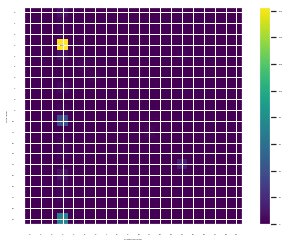

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [38]:
modelo_ab = AdaBoostClassifier()

n_estimators = [10,25,64,100,128,200]
param_grid = {'n_estimators':n_estimators}

modelo_grid_ab = GridSearchCV(modelo_ab,param_grid=param_grid)
modelo_grid_ab.fit(scaled_X_train,y_train)
cr_ab = reportar(modelo_grid_ab)

### Comparando os modelos.
Vamos compilar e verificar graficamente os valores dos relatórios de classificação reportados demonstrado acima para comparar a performance dos modelos.

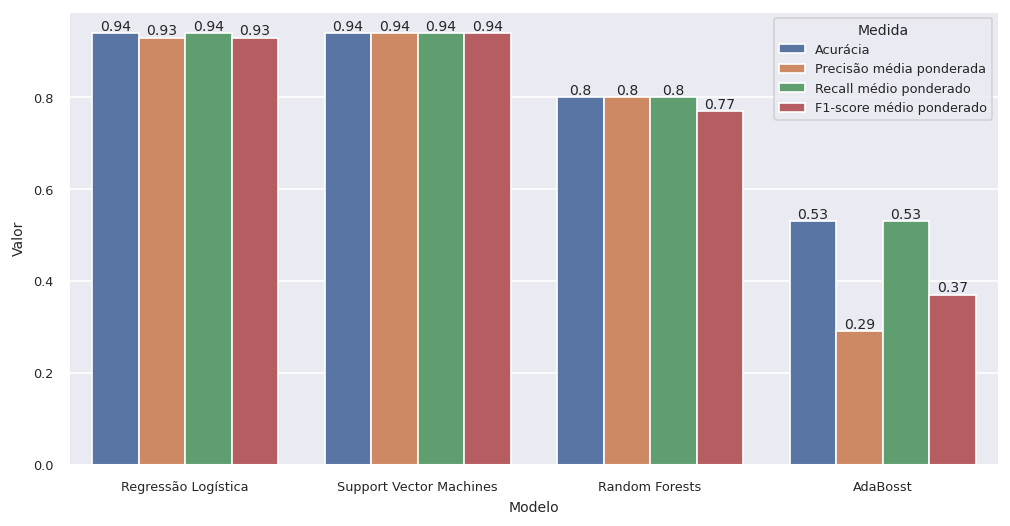

In [126]:
resultados = {'Modelo':['Regressão Logística','Support Vector Machines','Random Forests','AdaBosst'],
             'Acurácia':[cr_log[1175:1179],cr_svm[1175:1179],cr_rf[1175:1179],cr_ab[1175:1179]],
             'Precisão média ponderada':[cr_log[1263:1267],cr_svm[1263:1267],cr_rf[1263:1267],cr_ab[1263:1267]],
             'Recall médio ponderado':[cr_log[1273:1277],cr_svm[1273:1277],cr_rf[1273:1277],cr_ab[1273:1277]],
             'F1-score médio ponderado':[cr_log[1283:1287],cr_svm[1283:1287],cr_rf[1283:1287],cr_ab[1283:1287]]}

df_res = pd.DataFrame(resultados)
df_res['Acurácia'] = pd.to_numeric(df_res['Acurácia'])
df_res['Precisão média ponderada'] = pd.to_numeric(df_res['Precisão média ponderada'])
df_res['Recall médio ponderado'] = pd.to_numeric(df_res['Recall médio ponderado'])
df_res['F1-score médio ponderado'] = pd.to_numeric(df_res['F1-score médio ponderado'])

df_res = pd.melt(df_res, id_vars='Modelo',var_name="Medida",value_name="Valor")

plt.figure(dpi=120,figsize=(10,5))
ax = sns.barplot(data=df_res,x='Modelo',y='Valor',hue='Medida')
sns.set(font_scale=0.7)

for i in range(4):
    ax.bar_label(ax.containers[i])

plt.show()

É possível verificar que o classificador SVM foi o melhor de todos. Utilizando-o, vamos demonstrar como seria feita a recomendação simulando uma compra que teria os mesmos produtos que o primeiro pedido em X tem.<p>
Em primeiro lugar devemos descobrir a classe do cliente.

In [155]:
classe_sim = modelo_grid_svm.predict(df[cols_int].iloc[[0]])
classe_sim

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


array([32], dtype=int32)

Em seguida devemos ver quais são os produtos da classe.

In [156]:
prods_grupos[int(classe_sim)]

['couve',
 'mamao',
 'banana prata',
 'coco verde',
 'limao',
 'ovos caipira',
 'batata doce',
 'alface crespa',
 'cajuina',
 'macaxeira',
 'castanha de caju (natural)',
 'jerimum leite',
 'biscoito de castanha',
 'queijo coalho',
 'banana maca',
 'queijo coalho (500g)',
 'agua de coco',
 'jerimum caboclo',
 'feijao verde',
 'feijao de corda',
 'berin',
 'mel de abelha',
 'arroz',
 'galinha caipira',
 'goma',
 'tomate cereja',
 'carne de porco',
 'carne de carneiro',
 'castanha de caju (salgada)',
 'macaxeira pre-cozida',
 'doce de leite',
 'goma fresca para tapioca',
 'melancia',
 'coco seco',
 'milho verde',
 'doce de goiaba',
 'corante de urucum',
 'adubo organico',
 'cocada branca',
 'arroz integral',
 'farinha de mandioca branca',
 'cafe',
 'doce de caju',
 'linguica artesanal - condimentada',
 'rapadura de caju',
 'suco de uva',
 'gergelim',
 'manteiga da terra',
 'sal temperado',
 'fava',
 'farinha de mandioca amarela',
 'linguica artesanal - tradicional',
 'alho temperado',
 'g

Por fim verificaríamos se o primeiro produto da lista está no carrinho de compras. Caso esteja, faríamos o mesmo para o segundo, o terceiro, e assim por diante até encontrar algum que não estivesse.

In [158]:
df[['qt_couve','qt_mamao']].iloc[[0]]

,qt_couve,qt_mamao
0,2.0,0.0


Para este cliente seria sugerido o mamão.

**Importante:** ao exportar o classificador, é necessário também exportar o scaler pois deverão ser passados ao classificador os dados normalizados, já que ele foi treinado com dados normalizados.